## Setup

In [1]:
import pandas as pd
import sqlite3 as s3
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

go_sales = s3.connect('go_sales.sqlite')

order_details = pd.read_sql_query('SELECT * FROM order_details', go_sales)
order_header = pd.read_sql_query('SELECT * FROM order_header', go_sales)
returned_item = pd.read_sql_query('SELECT * FROM returned_item', go_sales)

/var/folders/p3/ww91cz713915js7fdqnjqhvm0000gn/T/ipykernel_25541/3558329377.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Trainset

In [2]:
merged_orders = pd.merge(order_details, order_header, left_on='ORDER_NUMBER', how='inner', right_on='ORDER_NUMBER')
df = pd.merge(merged_orders, returned_item, left_on='ORDER_DETAIL_CODE', how='outer', right_on='ORDER_DETAIL_CODE')
df = df[['PRODUCT_NUMBER', 'QUANTITY', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'RETAILER_SITE_CODE', 'ORDER_DATE', 'RETURN_DATE', 'RETURN_REASON_CODE']]

# Om de RETURN_DATE mee te geven aan de trainset. Format de data en vervolgens afsplitsen in dag maand jaar.
df['RETURN_DATE'] = pd.to_datetime(df['RETURN_DATE'], format="%d-%m-%Y %H:%M:%S")
df['RETURN_DAY'] = df['RETURN_DATE'].dt.day
df['RETURN_MONTH'] = df['RETURN_DATE'].dt.month
df['RETURN_YEAR'] = df['RETURN_DATE'].dt.year
df = df.drop('RETURN_DATE', axis=1)

# Om de afgesplitste RETURN_DATE dagen maanden en jaren te vullen met 0, als de bestelling niet is geretourneerd en dus geen RETURN_DATE heeft.
df['RETURN_DAY'] = df['RETURN_DAY'].fillna(0).astype(int)
df['RETURN_MONTH'] = df['RETURN_MONTH'].fillna(0).astype(int)
df['RETURN_YEAR'] = df['RETURN_YEAR'].fillna(0).astype(int)

# Om de ORDER_DATE af te splitsen in dag maand en jaar.
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])
df['ORDER_DAY'] = df['ORDER_DATE'].dt.day
df['ORDER_MONTH'] = df['ORDER_DATE'].dt.month
df['ORDER_YEAR'] = df['ORDER_DATE'].dt.year
df = df.drop('ORDER_DATE', axis=1)

# Vult de RETURN_REASON_CODE met 0 voor de bestellingen die niet geretourneerd zijn.
df['RETURN_REASON_CODE'] = df['RETURN_REASON_CODE'].fillna(0).astype(int)

# Een filter om de trainset alleen de geretourneerde bestellingen mee te geven. Comment voor álle bestellingen, uncomment voor alleen de geretourneerde bestellingen.
df = df[df['RETURN_REASON_CODE'] != 0]
df

,PRODUCT_NUMBER,QUANTITY,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETURN_REASON_CODE,RETURN_DAY,RETURN_MONTH,RETURN_YEAR,ORDER_DAY,ORDER_MONTH,ORDER_YEAR
143,15,16,756.82,593.5,327,4,9,8,2021,26,7,2021
146,16,64,2.05,2.05,330,5,6,7,2021,28,6,2021
196,30,22,13.57,13.57,327,4,6,7,2021,25,6,2021
247,43,52,189.77,189.77,327,1,14,12,2021,23,10,2021
634,111,6,180.13,180.13,331,4,19,12,2021,3,12,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
42809,15,16,831.88,626.94,326,1,9,11,2020,16,10,2020
42816,17,34,90.09,90.09,329,1,18,8,2020,1,8,2020
42876,33,70,29.44,29.44,326,1,22,11,2020,27,9,2020
42879,34,54,51.24,51.24,329,3,17,10,2020,6,10,2020


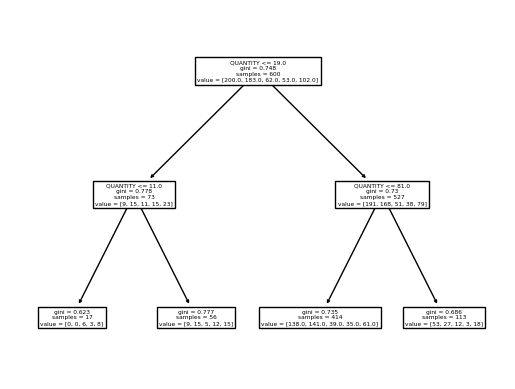

In [3]:
x = df.drop('RETURN_REASON_CODE', axis = 1)
y = df.loc[:, ['RETURN_REASON_CODE']]
x

x_train, x_text, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

dtree = DecisionTreeClassifier(max_depth=2)
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names=x.columns)
plt.show()

In [4]:
predicted_df = pd.DataFrame(dtree.predict(x_text))
predicted_df = predicted_df.rename(columns={0:'Predicted Reason Code'})
model_results_frame = pd.concat([y_test.reset_index()['RETURN_REASON_CODE'], predicted_df], axis=1)
# filter = model_results_frame['Predicted Reason Code'] != 0
# model_results_frame = pd.DataFrame(model_results_frame.loc[filter, :])
model_results_frame

,RETURN_REASON_CODE,Predicted Reason Code
0,1,2
1,1,2
2,1,2
3,1,2
4,1,1
...,...,...
101,2,1
102,4,5
103,1,2
104,5,2


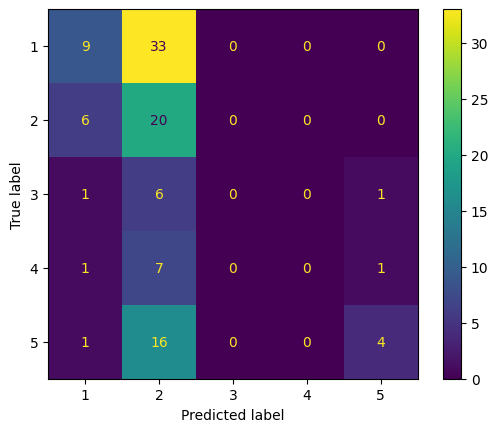

In [5]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted Reason Code'])
# Uncomment voor álle bestellingen.
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5])
# Uncomment voor alleen de geretourneerde bestellingen.
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [6]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted Reason Code'])

0.3113207547169811